In [1]:
# Imports

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

# Models

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

#Deep learning
from tensorflow.keras import models, Sequential, layers
from keras import callbacks
from sklearn.model_selection import KFold

from sklearn import set_config; set_config(display='diagram')

2022-03-02 17:48:54.079300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 17:48:54.079354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load

In [2]:
#load houses dataset
houses = pd.read_csv('data/train.csv')
X = houses.drop(columns=['SalePrice', 'Id'])
y = houses['SalePrice']

In [3]:
#check features shape
X.shape

(1460, 79)

# 🐣 1. BASELINE

## 1.1 Initial feature overview

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
#unique values for each categorical feature in training set
feat_categorical_nunique = X.select_dtypes(include='object').nunique().to_frame()

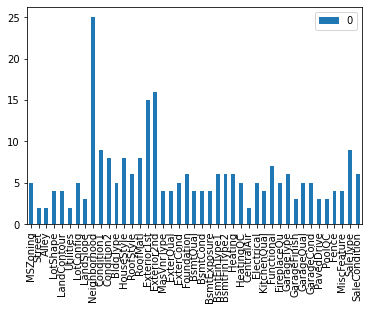

In [6]:
#unique value per categorical features
feat_categorical_nunique.plot(kind='bar');

In [7]:
#remove features that have 7 unique values or more
feat_categorical_small = feat_categorical_nunique.where(feat_categorical_nunique[0] < 7).dropna().index.tolist()

## 1.2 Baseline pipe

### a) Preprocessing

In [8]:
#Start features preprocessing
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown = 'ignore'))
num_col = make_column_selector(dtype_include=['float64', 'int64'])
cat_col = make_column_selector(dtype_include=['object'])
preproc_baseline = make_column_transformer((cat_transformer, feat_categorical_small),
    (num_transformer, num_col),
    remainder = 'drop')

In [9]:
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQua...
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...]),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6fe47e4fa0>)])

In [10]:
#transform x
X_transformed = preproc_baseline.fit_transform(X)

In [11]:
#check trasnsformed df shape
shape_preproc_baseline = X_transformed.shape
shape_preproc_baseline

(1460, 183)

### b) Add estimator

In [12]:
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQu...
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...]),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6fe47e4fa0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### c) Cross-Validate

In [13]:
# Create RMSLE and negative RMSLE scorer as requested by kaggle

def root_mean_squared_log_error(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)
    log_error = np.log(1+t) - np.log(1+p)
    return ((log_error**2).mean())**0.5

def root_mean_squared_log_error_neg(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)
    log_error = np.log(1+t) - np.log(1+p)
    return -((log_error**2).mean())**0.5


rmsle = make_scorer(root_mean_squared_log_error, greater_is_better=False)
rmsle_neg = make_scorer(root_mean_squared_log_error_neg, greater_is_better=True)

In [14]:
# Check baseline score
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()

score_baseline

-0.2159892542471893

### d) Predict baseline

In [15]:
# predict test prices with baseline model
test = pd.read_csv('data/test.csv')
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [16]:
pipe_baseline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQu...
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...]),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6fe47e4fa0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [17]:
y_pred_baseline = pd.DataFrame(pipe_baseline.predict(test))
y_pred_baseline

,0
0,127500.0
1,157900.0
2,192000.0
3,168000.0
4,220000.0
...,...
1454,84500.0
1455,83500.0
1456,139000.0
1457,93500.0


In [18]:
# Create csv to upload to kaggle
headers = ['Id','SalePrice']
y_pred_baseline.to_csv(r'data/submission_baseline.csv', index_label='Id', header=['SalePrice'])

# 🏋️‍♀️ 2. ITERATIONS 

In [19]:
# Test RandomForest estimator score

pipe_rf = make_pipeline(preproc_baseline, RandomForestRegressor(n_estimators=200))

rf_results = cross_val_score(pipe_rf, X, y, scoring=rmsle).mean()

rf_results

-0.14635769670359883

In [20]:
# Test Bagging estimator score

weak_learner = RandomForestRegressor(n_estimators=50)
bagged_model = BaggingRegressor(weak_learner, n_estimators=30)

pipe_bagged = make_pipeline(preproc_baseline, bagged_model)

bagged_results = cross_val_score(pipe_bagged, X, y, scoring=rmsle).mean()
bagged_results

-0.14646261164678712

In [21]:
# Test Adaboost estimator score

adaboost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=3),
    n_estimators=50)

pipe_adaboost = make_pipeline(preproc_baseline, adaboost)

adaboost_results = cross_val_score(pipe_adaboost, X, y, scoring=rmsle, cv=5).mean()
adaboost_results

-0.2060457731330409

In [22]:
# Test GradientBoost estimator score

gbr = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=3)

pipe_gbr = make_pipeline(preproc_baseline, adaboost)

gbr_results = cross_val_score(pipe_gbr, X, y, scoring=rmsle, cv=5).mean()
gbr_results

-0.20176431202418404

In [23]:
# Test Xgboost estimator score

xgb_reg = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.01)

pipe_xgb = make_pipeline(preproc_baseline, xgb_reg)

xgb_results = cross_val_score(pipe_xgb, X, y, scoring=rmsle, cv=5).mean()
xgb_results

-0.1450594809544984

In [24]:
# Try ensemble estimator 

forest = RandomForestRegressor(n_estimators=100)
KNNreg = KNeighborsRegressor(n_neighbors=10)


ensemble = VotingRegressor(
    estimators = [("rf", forest),("KNN", KNNreg), ('xgb', xgb_reg), ('gbr', gbr)]
)

pipe_ensemble = make_pipeline(preproc_baseline, ensemble)

ensemble_results = cross_val_score(pipe_ensemble, X, y, scoring=rmsle, cv=5).mean()
ensemble_results

-0.13907574067927186

In [25]:
#fit model
pipe_ensemble.fit(X, y)
stacked_pred = pipe_ensemble.predict(test)
pipe_ensemble.predict(test).shape

(1459,)

In [26]:
#create predictions df and csv
table = pd.DataFrame({'Id': test['Id'].tolist(), 'SalePrice': stacked_pred})
table.set_index('Id', inplace=True)
table.to_csv('data/answer.csv')

## 2.1 Preprocessing Iteration ♲ 

### a) Ordinal Encoding

In [27]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

In [28]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [29]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [30]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [31]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [32]:
pd.DataFrame(preproc.fit_transform(X,y)).head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.0,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [33]:
forest = RandomForestRegressor(n_estimators=300)
KNNreg = KNeighborsRegressor()

xgb = XGBRegressor(max_depth=20, n_estimators=100, learning_rate=0.01)

ensemble = VotingRegressor(
    estimators = [("rf", forest), ("KNN", KNNreg), ('xgb', xgb)]
)
#preproc_pipe = make_pipeline(preproc_encoded, SelectPercentile='mutual_info_regression')

pipe_ensemble_enc = make_pipeline(preproc, ensemble)


ensemble_enc_results = cross_val_score(pipe_ensemble_enc, X, y, scoring=rmsle, cv=5).mean()
ensemble_enc_results

-0.1904549252337493

In [34]:
pipe_xgb = make_pipeline(preproc, xgb)para 

cross_val_score(pipe_xgb,X,y,cv=5,scoring=rmsle,n_jobs=-1).mean()

-0.47988542790987215

In [35]:
pipe_ensemble_enc.fit(X, y)
stacked_pred2 = pipe_ensemble_enc.predict(test)
table = pd.DataFrame({'Id': test['Id'].tolist(), 'SalePrice': stacked_pred2})
table.set_index('Id', inplace=True)
table.to_csv('data/answer2.csv')

### b) Statistical Feature Selection

In [36]:
#Use SelectPercentile to filter 
preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6fe467db80>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x7f704edd25e0>))])

In [37]:
# New Estimators

# ensemble
pipe_ensemble_enc = make_pipeline(preproc, ensemble)


ensemble_enc_results = cross_val_score(pipe_ensemble_enc, X, y, scoring=rmsle, cv=5).mean()
ensemble_enc_results

-0.19437038138835422

In [38]:
#Random Forest
pipe_rf_2 = make_pipeline(preproc, RandomForestRegressor(n_estimators=200))

rf_results = cross_val_score(pipe_rf_2, X, y, scoring=rmsle).mean()

rf_results

-0.14402748872424626

In [39]:
#XGB

xgb_reg_2 = XGBRegressor(max_depth=10, n_estimators=500, learning_rate=0.01)

pipe_xgb_2 = make_pipeline(preproc, xgb_reg_2)

xgb_results_2 = cross_val_score(pipe_xgb_2, X, y, scoring=rmsle, cv=5).mean()

xgb_results_2

-0.1385708089900405

In [40]:
# Save final results for submission

pipe_xgb_2.fit(X, y)
final_pred = pipe_xgb_2.predict(test)
results = pd.DataFrame({'Id': test['Id'].tolist(), 'SalePrice': final_pred})
results.set_index('Id', inplace=True)
results.to_csv('data/finalpred.csv')

In [41]:
results.shape

(1459, 1)

# Deep Learning Approach

In [42]:
#Create test dataset and preprocess 

X_test = pd.read_csv('data/test.csv')
X_test_preproc = preproc.transform(X_test)

In [43]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1022, 79), (438, 79), (1022,), (438,))

In [44]:
# Fit the preprocessor on the train set
preproc.fit(X_train, y_train)

# Create the preprocessed versions of X_train and X_val
X_train_preproc = preproc.transform(X_train)
X_val_preproc = preproc.transform(X_val)

# Create the preprocessed version of X_test for our future predictions
X_test_preproc = preproc.transform(X_test)

In [45]:
#Create Deep Learning model

def initialize_model(X):

    #################################
    #  1 - Model architecture       #
    #################################
    
    model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(20, activation='relu', input_dim = X.shape[-1]))
    
    # Hidden Layers
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    
    # Predictive Layer
    model.add(layers.Dense(1, activation='linear'))
    
    ##################################
    #  2 - Our recommended compiler  #
    ##################################
    
    model.compile(optimizer='adam',
                  loss='msle')      # directly optimize for the squared log error!
    
    return model

In [46]:
#Set Early Stopping parameter
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)

In [47]:
# 1. Initializing a NeuralNet with its architecture and its compilation method
model = initialize_model(X_train_preproc)
model.summary()


# 2. Training the model
epochs = 500
batch_size = 16

history = model.fit(X_train_preproc, 
                    y_train,
                    validation_data = (X_val_preproc, y_val),
                    epochs = epochs,         
                    batch_size = batch_size,
                    callbacks =[earlystopping],
                    verbose = 0)

# 3. Evaluating the model
res = model.evaluate(X_val_preproc, y_val, verbose = 0)
print(f"RMLSE achieved after {epochs} epochs = {round(res**0.5,3)}")

# 4. Looking at the lowest loss
minimium_rmlse_val = min(history.history['val_loss'])**0.5
optimal_momentum = np.argmin(history.history['val_loss'])

print(f"Lowest RMLSE achieved = {round(minimium_rmlse_val,3)}")
print(f"This was achieved at the epoch number {optimal_momentum}") 

2022-03-02 18:01:41.095722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 18:01:41.096003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 18:01:41.096100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-02 18:01:41.096157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-02 18:01:41.096235: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1060      
                                                                 
 dense_1 (Dense)             (None, 30)                630       
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 20)                320       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,496
Trainable params: 2,496
Non-trainable params: 0
_________________________________________________________________
RMLSE achieved after 500 epochs = 0.122
Lowest RMLSE a

In [48]:
#function to plot train/val loss

def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

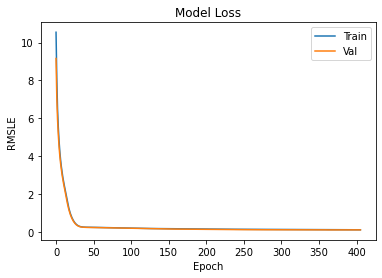

In [49]:
plot_history(history)

In [50]:
# Function to evaluate model
def evaluate_model(X, y, train_index, val_index):
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = initialize_model(X_train)
    
    history = model.fit(X_train, 
                        y_train,
                        validation_data = (X_val, y_val), 
                        epochs = 500,
                        batch_size = 16,
                        verbose=0)
    return pd.DataFrame({
                'rmsle_final_epoch': [model.evaluate(X_val, y_val)**0.5],
                'rmsle_min': [min(history.history['val_loss'])**0.5]
                        })

In [51]:
#set cross val values
cv = 5
kf = KFold(n_splits = cv, shuffle = True)
X_preproc = preproc.fit_transform(X,y)

In [52]:
#Save cross val scores to dataframe

results = []

for train_index, val_index in kf.split(X_preproc):
    results.append(evaluate_model(X_preproc, y, train_index, val_index))
    
pd.concat(results, axis = 0)

10/10 [==============================] - 0s 1ms/step - loss: 0.0375


,rmsle_final_epoch,rmsle_min
0,0.129009,0.127906
0,0.143734,0.131261
0,0.120694,0.120151
0,0.112617,0.110803
0,0.193771,0.177069


In [53]:
#Predict Values
prediction = model.predict(X_test_preproc)

In [54]:
#Save results to dataframe

results_dl = pd.concat([
                        test["Id"], 
                        pd.Series(prediction[:,0], name="SalePrice")
                    ],
                    axis=1)
results_dl

,Id,SalePrice
0,1461,130678.218750
1,1462,162594.796875
2,1463,188429.156250
3,1464,208619.890625
4,1465,179149.515625
...,...,...
1454,2915,86724.046875
1455,2916,87994.718750
1456,2917,174706.750000
1457,2918,114865.890625


In [55]:
#save results to csv for submission

results_dl.to_csv("data/submission_dl_final.csv", header = True, index = False)